# Projekt MSP1 / 2024
Cílem tohoto projektu je se seznámit s programovými nástroji využívaných ve statistice a osvojit si základní procedury. Projekt není primárně zaměřen na efektivitu využívání programového vybavení (i když úplně nevhodné konstrukce mohou mít vliv na hodnocení), ale nejvíce nás zajímají vaše statistické závěry a způsob vyhodnocení. Dbejte také na to, že každý graf musí splňovat nějaké podmínky - přehlednost, čitelnost, popisky.

V projektu budete analyzovat časy běhu šesti různých konfigurací algoritmů. Ke každé konfiguraci vzniklo celkem 200 nezávislých běhů, jejichž logy máte k dispozici v souboru [logfiles.zip](logfiles.zip).

Pokud nemáte rozchozené prostředí pro pro spouštění Jupyter notebooku, můžete využití službu [Google Colab](https://colab.google/). Jakákoliv spolupráce, sdílení řešení a podobně je zakázána!

S případnými dotazy se obracejte na Vojtěcha Mrázka (mrazek@fit.vutbr.cz).

__Odevzdání:__ tento soubor (není potřeba aby obsahoval výstupy skriptů) do neděle 27. 10. 2024 v IS VUT. Kontrola bude probíhat na Pythonu 3.12.3 (standardní instalace Ubuntu); neočekává se však to, že byste používali nějaké speciality a nekompatibilní knihovny. V případě nesouladu verzí a podobných problémů budete mít možnost reklamace a prokázání správnosti funkce. Bez vyplnění vašich komentářů a závěrů do označených buněk nebude projekt hodnocen!

__Upozornění:__ nepřidávejte do notebooku další buňky, odpovídejte tam, kam se ptáme (textové komentáře do Markdown buněk)

__Tip:__ před odevzdáním resetujte celý notebook a zkuste jej spustit od začátku. Zamezíte tak chybám krokování a editací, kdy výsledek z buňky na konci použijete na začátku.

__OTÁZKA K DOPLNĚNÍ:__

Jakub Vlk a xvlkja07

## Načtení potřebných knihoven
Načtěte knihovny, které jsou nutné pro zpracování souborů a práci se statistickými funkcemi.

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import json
from zipfile import ZipFile

## Načtení dat do DataFrame
Ze souboru `logfiles.zip` umístěném ve stejném adresáři načtěte data a vytvořte Pandas DataFrame.

Výsledky jsou uložené ve formátu JSON - pro zpracování použijte knihovnu `json`.
Můžete využít následující kostru - je vhodné pracovat přímo se ZIP souborem. Jedinou nevýhodou může být to, že vám bude vracet _byte_ objekt, který musíte přes funkci `decode` zpracovat.

Upravte také pomocí funkce `.astype()` datové typy patřičných sloupců.

```py
data = []
with ZipFile("logfiles.zip") as zf:
    for filename in zf.namelist():
        # TODO test názvu souboru
        with zf.open(filename, "r") as f:
            pass # vytvořte slovník

df = pd.DataFrame(data)
df
```

In [16]:
data = []
with ZipFile("logfiles.zip") as zf:
    for filename in zf.namelist():
        if filename.endswith('.json'):
            with zf.open(filename, "r") as f:
                content = f.read().decode('utf-8')
                data.append(json.loads(content))

df = pd.DataFrame(data)
df["runtime"] = df["runtime"].astype(float)
df

,configuration,run,runtime,status
0,config6,149,53.733556,SUCCESS
1,config2,16,134.543496,SUCCESS
2,config6,180,117.108040,SUCCESS
3,config4,12,223.763044,SUCCESS
4,config5,193,159.540473,SUCCESS
...,...,...,...,...
1195,config5,95,199.461297,SUCCESS
1196,config5,99,155.491930,SUCCESS
1197,config2,83,125.243690,SUCCESS
1198,config5,153,223.312938,SUCCESS


## Analýza a čištění dat
Vhodným způsobem pro všechny konfigurace analyzujte časy běhů a pokud tam jsou, identifikujte hodnoty, které jsou chybné. Vyberte vhodný graf, který zobrazí samostatně jednotlivé konfigurace.

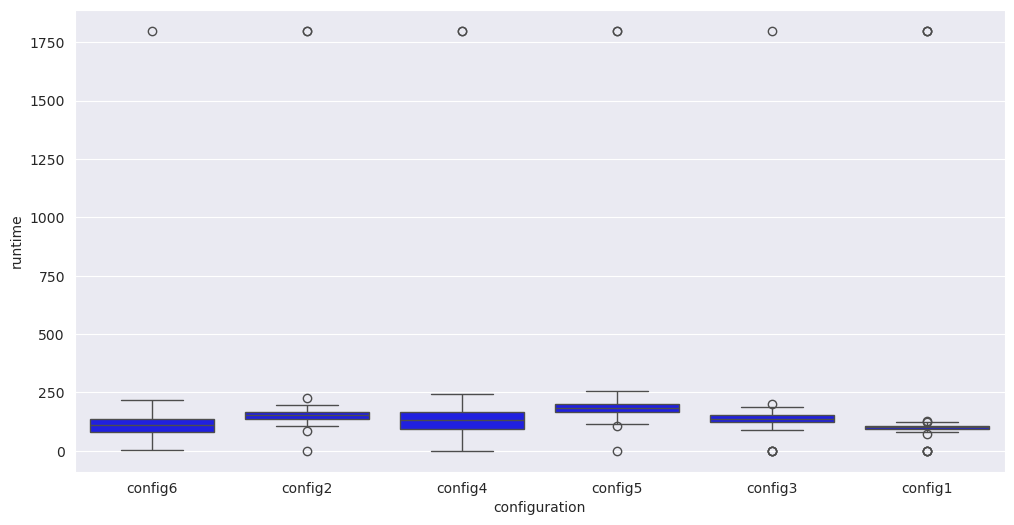

('Počet záznamů které jsou nejspíš chybné 23. Podíl chybných záznamů je pro jednotlivé konfigrace je zobrazen v tabulce: ',
 configuration  status    
 config1        SEGFAULT      0.020
                TIME LIMIT    0.015
 config2        SEGFAULT      0.005
                TIME LIMIT    0.010
 config3        SEGFAULT      0.020
                TIME LIMIT    0.005
 config4        SEGFAULT      0.010
                TIME LIMIT    0.010
 config5        SEGFAULT      0.005
                TIME LIMIT    0.010
 config6        TIME LIMIT    0.005
 dtype: float64,
 configuration
 config1    0.035
 config2    0.015
 config3    0.025
 config4    0.020
 config5    0.015
 config6    0.005
 dtype: float64)

In [17]:
plt.figure(figsize=(12, 6))
ax = sns.boxplot(x='configuration', y='runtime', data=df.reset_index(), color="blue")
plt.show()

f"Počet záznamů které jsou nejspíš chybné {len(df[df['status'] != 'SUCCESS'])}. Podíl chybných záznamů je pro jednotlivé konfigrace je zobrazen v tabulce: ", df[df['status'] != 'SUCCESS'].groupby(['configuration',"status"]).size()/df.groupby('configuration').size(),  df[df['status'] != 'SUCCESS'].groupby(['configuration']).size()/df.groupby('configuration').size()

__OTÁZKA K DOPLNĚNÍ:__

_Objevily se nějaké chybné hodnoty? Proč tam jsou s ohledem na to, že se jedná o běhy algoritmů? Proč jste zvolili tento typ grafu?_

__Odpověď:__

Ano, objevily se chybné hodnoty. Hodnoty jsou zjevně chybné, protože jsou nápadně jiné než většina hodnot. Při bližším zkoumání je možné si všimnout, že tyto hodnoty mají jiný `status` než hodnoty vykazující obvyklé hodnoty.

Tyto hodnoty mají status buď `SEGFAULT` nebo `TIME LIMIT`. Zdá se, že záznamy se statusem `TIME LIMIT` jsou způsobeny zacyklením nebo jiným podobným problémem a záznamy s hodnotou status `SEGFAULT` jsou způsobeny chybou při běhu s tímto jménem. Tyto hodnoty nedává smysl analyzovat z pohledu rychlosti.

Pochopitelně je třeba se podívat, zda nějaká konfigurace nechybuje příliš často, čímž by sice mohla být rychlá, ale nemusela by být reálně použitelná. Ve výstupu předchozí buňky lze vidět, že nejchybovější konfigurace je konfigurace 1. Nejméně chybová je konfigurace 6.
 
Zvolili jsme krabicový graf (boxplot), protože je vhodný pro vizualizaci rozložení dat a umožňuje snadno identifikovat odlehlé hodnoty pro jednotlivé algoritmy.

Vyčistěte dataframe `df` tak, aby tam tyto hodnoty nebyly a ukažte znovu analýzu toho, že čištění dat bylo úspěšné. Odtud dále pracujte s vyčištěným datasetem.


Statistiky očištěných dat:
               count        mean        std         min         25%  \
configuration                                                         
config1        193.0   99.590413   9.386788   73.802549   92.979469   
config2        197.0  151.732975  19.833198   85.174653  137.995662   
config3        195.0  138.616959  19.867428   90.567110  124.803901   
config4        196.0  127.606156  50.282164    4.970286   94.793688   
config5        197.0  183.659767  28.729836  107.283620  164.070091   
config6        199.0  110.422689  40.875754    2.124534   81.656211   

                      50%         75%         max  
configuration                                      
config1         99.865028  104.824724  127.201692  
config2        151.516091  163.802880  227.054630  
config3        138.678404  151.536291  201.577616  
config4        129.975246  164.327163  241.987620  
config5        183.843132  201.250693  255.807973  
config6        111.043642  137.554141  

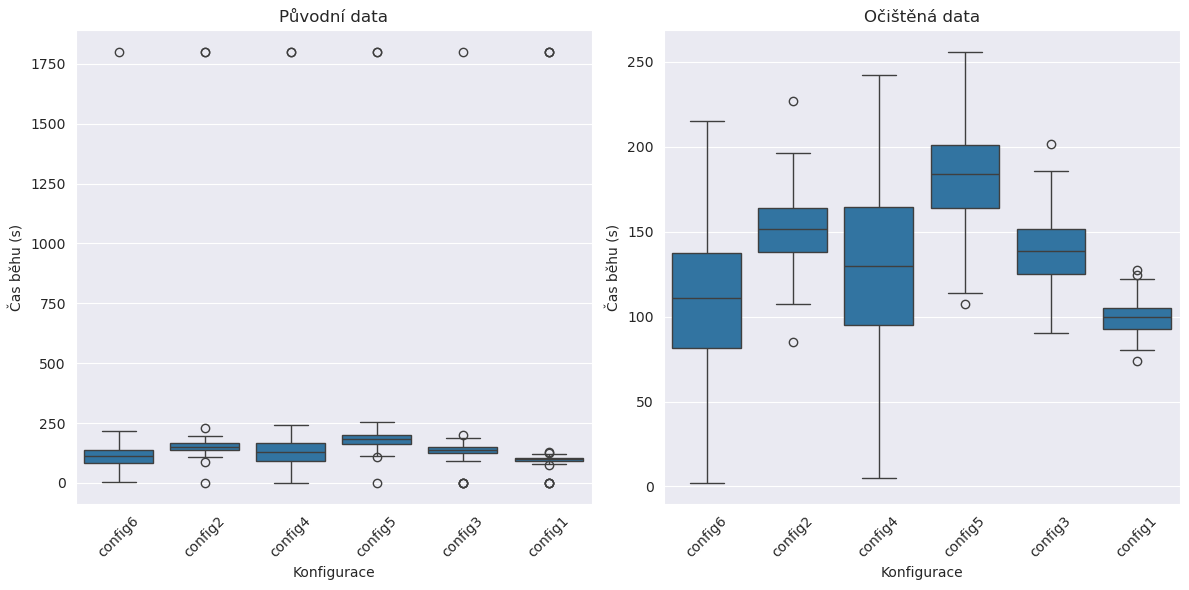

In [18]:

df_cleaned = df[(df['status'] == "SUCCESS")]

stats_cleaned = df_cleaned.groupby('configuration')['runtime'].describe()
print("\nStatistiky očištěných dat:")
print(stats_cleaned)

# Vytvoření figure a axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Graf pro původní data
sns.boxplot(x='configuration', y='runtime', data=df, ax=ax1)
ax1.set_title('Původní data')
ax1.set_xlabel('Konfigurace')
ax1.set_ylabel('Čas běhu (s)')
ax1.tick_params(axis='x', rotation=45)

# Graf pro očištěná data
sns.boxplot(x='configuration', y='runtime', data=df_cleaned, ax=ax2)
ax2.set_title('Očištěná data')
ax2.set_xlabel('Konfigurace')
ax2.set_ylabel('Čas běhu (s)')
ax2.tick_params(axis='x', rotation=45)

# Finální úpravy a zobrazení
plt.tight_layout()
plt.show()

## Deskriptivní popis hodnot
Vypište pro jednotlivé konfigurace základní deskriptivní parametry.  

__TIP__ pokud výsledky uložíte jako Pandas DataFrame, zobrazí se v tabulce.

In [19]:
df_cleaned[['configuration', 'runtime']].groupby("configuration").describe()
# nemá smysl analyzovat hodnoty run protože se jedná pouze o indexy

runtime                                                 \
                count        mean        std         min         25%   
configuration                                                          
config1         193.0   99.590413   9.386788   73.802549   92.979469   
config2         197.0  151.732975  19.833198   85.174653  137.995662   
config3         195.0  138.616959  19.867428   90.567110  124.803901   
config4         196.0  127.606156  50.282164    4.970286   94.793688   
config5         197.0  183.659767  28.729836  107.283620  164.070091   
config6         199.0  110.422689  40.875754    2.124534   81.656211   

                                                   
                      50%         75%         max  
configuration                                      
config1         99.865028  104.824724  127.201692  
config2        151.516091  163.802880  227.054630  
config3        138.678404  151.536291  201.577616  
config4        129.975246  164.327163  241.987620  
config5        183.843132  201.250693  255.807973  
config6        111.043642  137.554141  215.295283

__OTÁZKA K DOPLNĚNÍ:__

**Count**: Označuje počet běhů pro jednotlivé konfigurace algoritmů. Počet vzorků se pohybuje mezi 193 a 199 (vyčištěných).

**Mean**: Průměrné hodnoty ukazují, že nejrychlejším algoritmem je config1 s průměrným časem ~99,59 sekund, nejpomalejším je config5 s průměrným časem ~183,65 sekund. Druhý nejrychlejší je config6 s průměrným časem ~100,59 sekund.

**Standard deviation**: Směrodatná odchylka říká, jak moc se liší jednotlivé časy jednotlivých běhů. Nejmenší směrodatná odchylka je 9,39 (config1), což dokazuje, že algoritmus vrací nejkonzistentnější výsledky napříč běhy. Nejvyšší hodnotu má config4 50,28, kde je odchylka značná vzhledem k tomu, že se jedná o téměř polovinu průměrné hodnoty.

**Min**: Minimální hodnoty (tedy nejrychlejší běh) má konfigurace config6, a to sice ~2,12 s, což může znamenat, že tento algoritmus funguje opravdu dobře pro nějaké vstupy, a což může být značně výhodné, pokud tento vstup bude zastoupen často ve vstupních datech, neboť průměrná hodnota této konfigurace je druhou nejlepší. Nicméně jak je vidno z předešlého sloupce a sloupce udávajícího průměr, tak si tento výkon (myšleno minimální hodnotu) neuchovává napříč všemi běhy. Taktéž je možné, že se jedná o chybu měření. Nejvyšší minimální čas byl 107,28 (config5).

**{25, 50, 75} percentil** - určují hranice, pod kterými se nachází n % všech hodnot

**Max**: Maximální hodnoty se pohybují od 127,20 (config1) po 255,81 (config5).



## Vizualizace
Vizualizujte časy běhů algoritmů tak, aby byl v jednom grafu zřejmý i rozptyl hodnot, avšak bylo možné porovnání. Zvolte vhodný graf, který pak níže komentujte.

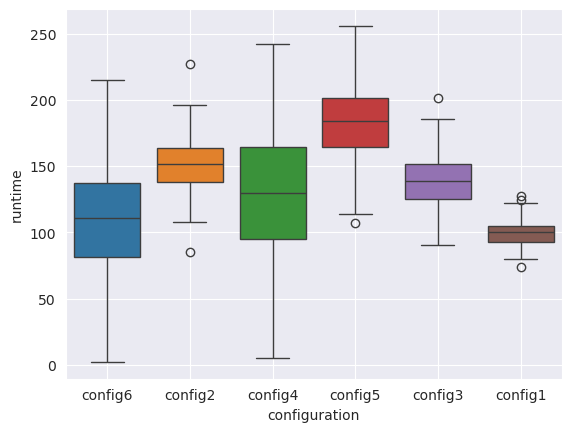

In [20]:
ax = sns.boxplot(x="configuration", y="runtime", data=df_cleaned, hue="configuration")
ax.grid(True)

__OTÁZKA K DOPLNĚNÍ:__

Pro vizualizaci časů běhu algoritmů jsem použil boxplot z knihovny seaborn, kde na x-ové ose zobrazujeme konfigurace jednotlivých běhů a na y-ové ose čas běhu. Boxplot graf je vhodný pro zobrazení deskriptivního popisu hodnot různých běhů algoritmů, protože v grafu přímo vidíme porovnání různých konfigurací spolu s mediánem (prostřední čára v krabici), prvním (25%) a třetím (75%) kvartilem - hranice "krabice", nebo "odlehlými hodnotami" (extrémní hodnoty mimo boxplot graf).

Na první pohled můžeme vidět, že konfigurace 1 má pro všechny běhy nejnižší průměr a je nejrychlejší, zatímco konfigurace 5 je nejpomalejší. Konfigurace 6 má největší rozptyl hodnot, což může znamenat, že tento algoritmus je nejvíce citlivý na vstupní data. Taktéž můžeme znovu vidět, že konfigurace 1 má suverénně nejkonzistentnější výsledky z důvodu nízké odchylky hodnot.

Graf také ukazuje, že ačkoliv jsme provedli čištění dat, stále se v datech vyskytují odlehlé hodnoty, které mohou být způsobeny chybou v měření nebo jiným problémem. Nejspíš by bylo vhodné se zaměřit na analýzu takových běhů a zjistit, co je způsobuje a zda se jedná o validní data.

## Určení efektivity konfigurací algoritmů
Nás ale zajímá, jaká konfigurace je nejrychlejší. Z výše vykresleného grafu můžeme vyloučit některé konfigurace. Existuje tam však minimálně jedna dvojice, u které nedokážeme jednoznačně určit, která je lepší - pokud nebudeme porovnávat pouze extrémní hodnoty, které mohou být dané náhodou, ale celkově. Proto proveďte vhodný test významnosti - v následující části diskutujte zejména rozložení dat (i s odkazem na předchozí buňky, variabilitu vs polohu a podobně). Je nutné každý logický krok a výběry statistických funkcí komentovat. 

Vužijte vhodnou funkci z knihovny `scipy.stats` a funkci poté __implementujte sami__ na základě základních matematických funkcí knihovny `numpy` případně i funkcí pro výpočet vybraného rozložení v [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html). Při vlastní implementaci není nutné se primárně soustředit na efektivitu výpočtu (není potřeba využít všechny funkce numpy, můžete použít normální cykly a podobně - v hodnocení však bude zahrnuta přehlednost a neměly by se objevit jasné chyby, jako je zvýšení třídy složitosti a podobně).

__OTÁZKA K DOPLNĚNÍ:__
_Jaká data budete zkoumat? Jaké mají rozložení a parametry (např. varianci) a jaký test použijete? Jaká je nulová hypotéza? Jak se liší variabilita a poloha vybraných konfigurací?_

Ke zkoumání se zdají být nejvýhodnější data konfigurace 1 a 6. 

Krom rychlosti by mohla být zajímavá i chybovost. Jak je vidět z tabulky, konfigurace 1 má chybovost 3,5 % (nejchybovější) a konfigurace 6 0,5 %. To znamená, že konfigurace 6 je nejméně chybová, což ji činí nejméně chybovou napříč všemi konfiguracemi. V rámci zadání není specifikováno, zda má být toto předmětem výběru, ale podle mě je vhodné upozornit na tento fakt. Podle mého názoru by bylo vhodné zaměřit se na chybové běhy a zjistit příčinu chyby (SEGFAULT nebo TIME LIMIT), protože chyba může být i na straně vstupu, a ne nutně algoritmu.

| configuration | chybovost |
|---------------|-----------|
| config1       | 0,035     |
| config2       | 0,015     |
| config3       | 0,025     |
| config4       | 0,020     |
| config5       | 0,015     |
| config6       | 0,005     |

Data v každé konfiguraci mají normální rozdělení. Lze to poznat z boxplotu, nicméně jsem se přesvědčil i pomocí histogramu, který zde neuvádím, abych nezměnil strukturu notebooku. Taktéž jsem provedl statistický test pro normální rozdělení (jak je vidno v tabulce kde u zkoumaných konfigurací je hodnota P pro test normálnosti vždy velmi vysoká). Parametry normálních rozdělení lze vidět v tabulce:

| configuration | variance     | skewness | kurtosis  | P-hodnota testu normálnosti |
|---------------|--------------|----------|-----------|-----------------------------|
| config1       | 88,111791    | 0,140597 | -0,009456 | 0.696753                    |
| config2       | 393,355739   | 0,172866 | 0,753914  | 0.089010                    |
| config3       | 394,714708   | 0,152578 | -0,096630 | 0.668268                    |
| config4       | 2528,295979  | -0,084451| -0,396185 | 0.425736                    |
| config5       | 825,403473   | 0,100101 | -0,251496 | 0.696839                    |
| config6       | 1670,827284  | 0,048833 | -0,157505 | 0.924317                    |

Nyní je potřeba provést statistický test, který definitivně rozhodne, zda je lepší konfigurace 1 nebo 6. Na identifikaci lepšího algoritmu použijeme dvouvýběrový (porovnáváme dvě hodnoty dvou rozdělení) nepárový (hodnoty jsou nezávislé) T-test (změněno na "pro") porovnání shody středních hodnot rozdělení. Nulovou hypotézou proto bude: **H0: Střední hodnoty časů běhů konfigurací config1 a config6 jsou stejné**.

In [28]:
# implementace s vyuzitim knihovni funkce

# vyber dat pro vybrane konfigurace - pro provedeni testu staci sloupec time
df_config1 = df_cleaned[df_cleaned['configuration'] == 'config1']['runtime']
df_config6 = df_cleaned[df_cleaned['configuration'] == 'config6']['runtime']

# zvolena hladina vyznamnosti
alpha = 0.05

t_statistic, p_value = stats.ttest_ind(df_config1, df_config6, equal_var=False)

print("Závěr:")
if p_value < alpha:
    print(f"Na hladině významnosti {alpha} zamítáme nulovou hypotézu.")
    if t_statistic < 0:
        print("Konfigurace1 je statisticky významně lepší (má nižší runtime) než konfigurace6.")
    else:
        print("Konfigurace1 je statisticky významně horší (má vyšší runtime) než konfigurace6.")
else:
    print(f"Na hladině významnosti {alpha} nezamítáme nulovou hypotézu.")
    print("Nemáme dostatek důkazů k prohlášení, že existuje statisticky významný rozdíl mezi konfiguracemi.")

print("p_value: ", p_value)
print("t_statistic: ", t_statistic)

df.groupby(["configuration"])[["runtime"]].apply(stats.normaltest)

print("\n Parametry normální rozdělení:")
stats_by_config = df_cleaned.groupby('configuration')['runtime'].agg([
    lambda x: x.var(),
    lambda x: stats.skew(x),
    lambda x: stats.kurtosis(x),
    lambda x: stats.normaltest(x)[1]
])

stats_by_config.columns = ['variance', 'skewness', 'kurtosis', "normaltest"]

print(stats_by_config)

Závěr:
Na hladině významnosti 0.05 zamítáme nulovou hypotézu.
Konfigurace1 je statisticky významně lepší (má nižší runtime) než konfigurace6.
p_value:  0.0003391848275884963
t_statistic:  -3.64068343471875

 Parametry normální rozdělení:
                  variance  skewness  kurtosis  normaltest
configuration                                             
config1          88.111791  0.140597 -0.009456    0.696753
config2         393.355739  0.172866  0.753914    0.089010
config3         394.714708  0.152578 -0.096630    0.668268
config4        2528.295979 -0.084451 -0.396185    0.425736
config5         825.403473  0.100101 -0.251496    0.696839
config6        1670.827284  0.048833 -0.157505    0.924317


T__OTÁZKA K DOPLNĚNÍ:__

_Jaký je závěr statistického testu?_

Hypotéza je zamítnuta. Nicméně hodnota `t_statistic` je záporná, což znamená, že konfigurace 1 je statisticky významně lepší (má nižší runtime) než konfigurace 6. Tedy na hladině významnosti \alpha (zvolena 0,05) je konfigurace 1 rychlejší.


### Vlastní implementace
Implementujte stejný test pomocí knihovních funkcí a ukažte, že je výsledek stejný.

In [ ]:
# zvolena hladina vyznamnosti
alpha = 0.05
t_statistic = (df_config1.mean() - df_config6.mean()) / np.sqrt(
    df_config6.var() / df_config6.count() + df_config1.var() / df_config1.count())
p_value = - stats.t.ppf(1 - alpha, df_config1.count() + df_config6.count() - 2)

print("Závěr:")
if p_value < alpha:
    print(f"Na hladině významnosti {alpha} zamítáme nulovou hypotézu.")
    if t_statistic < 0:
        print("Konfigurace1 je statisticky významně lepší (má nižší runtime) než konfigurace6.")
    else:
        print("Konfigurace1 je statisticky významně horší (má vyšší runtime) než konfigurace6.")
else:
    print(f"Na hladině významnosti {alpha} nezamítáme nulovou hypotézu.")
    print("Nemáme dostatek důkazů k prohlášení, že existuje statisticky významný rozdíl mezi konfiguracemi.")

print("p_value: ", p_value)
print("t_statistic: ", t_statistic)
